# [STARTER] Udaplay Project

## Part 02 - Agent

In this part of the project, you'll use your VectorDB to be part of your Agent as a tool.

You're building UdaPlay, an AI Research Agent for the video game industry. The agent will:
1. Answer questions using internal knowledge (RAG)
2. Search the web when needed
3. Maintain conversation state
4. Return structured outputs
5. Store useful information for future use

### Setup

In [21]:
# Only needed for Udacity workspace

import importlib.util
import sys

# Check if 'pysqlite3' is available before importing
if importlib.util.find_spec("pysqlite3") is not None:
    import pysqlite3
    sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [22]:
import os
import json
import textwrap
import chromadb

from lib.llm import LLM
from lib.agents import Agent
from lib.tooling import tool
from datetime import datetime
from dotenv import load_dotenv
from tavily import TavilyClient
from typing import List, Dict, Any
from pydantic import BaseModel, Field

from lib.state_machine import Run
from lib.vector_db import VectorStoreManager
from lib.documents import Document, Corpus

from chromadb.utils.embedding_functions import OllamaEmbeddingFunction
from lib.messages import UserMessage, SystemMessage, ToolMessage, AIMessage



In [23]:
# Load environment variables from config.env
load_dotenv('config.env', override=True)

assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('OPENAI_BASE_URL') is not None
assert os.getenv('TAVILY_API_KEY') is not None
assert os.getenv('CHROMA_OPENAI_API_KEY') is not None

In [24]:
# Verify that the Tavily client works
tavily_client = TavilyClient(api_key=os.getenv('TAVILY_API_KEY'))
response = tavily_client.search(
    query="Latest AI news",
    search_depth="basic",  
    max_results=1
)

print(response)

{'query': 'Latest AI news', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025', 'content': 'Summary: Apple has officially announced that a completely reimagined, AI-powered version of Siri is set to debut in 2026. This fundamental transformation will', 'score': 0.99950445, 'raw_content': None}], 'response_time': 0.68, 'request_id': '1912b94c-666e-4d70-b387-5a16c0d8240e'}


In [25]:
manager = VectorStoreManager(
    openai_api_key=os.getenv('OPENAI_API_KEY'),
    api_base="https://openai.vocareum.com/v1"
)
store = manager.get_or_create_store("udaplay")

# Load all games (original 15 + 5 new) into the in-memory store
data_dir = "games"
corpus = Corpus()
all_games = []
for file_name in sorted(os.listdir(data_dir)):
    if not file_name.endswith(".json"):
        continue
    with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
        game = json.load(f)
    content = (
        f"[{game['Platform']}] {game['Name']} ({game['YearOfRelease']}) "
        f"— Genre: {game['Genre']}. Publisher: {game['Publisher']}. "
        f"{game['Description']}"
    )
    corpus.append(Document(id=os.path.splitext(file_name)[0], content=content, metadata=game))
    all_games.append(game)

store.add(corpus)
print(f"VectorStore udaplay ready — {len(corpus)} documents loaded")

VectorStore udaplay ready — 20 documents loaded


### Tools

Build at least 3 tools:
- retrieve_game: To search the vector DB
- evaluate_retrieval: To assess the retrieval performance
- game_web_search: If no good, search the web


#### Retrieve Game Tool

In [26]:
@tool
def retrieve_game(query: str) -> str:
    """Semantic search: Finds most relevant results in the vector DB.
    args:
    - query: a question about game industry.

    You'll receive results as list. Each element contains:
    - Platform: like Game Boy, Playstation 5, Xbox 360...
    - Name: Name of the Game
    - YearOfRelease: Year when that game was released for that platform
    - Description: Additional details about the game
    """
    results = store.query(query_texts=[query], n_results=3)
    output = []
    for doc, dist, meta in zip(
        results["documents"][0], results["distances"][0], results["metadatas"][0]
    ):
        output.append(
            f"Name: {meta['Name']} | Platform: {meta['Platform']} | "
            f"Year: {meta['YearOfRelease']} | Genre: {meta['Genre']} | "
            f"Publisher: {meta['Publisher']} | Distance: {dist:.4f}\n"
            f"Description: {meta['Description']}"
        )
    return "\n---\n".join(output)

#### Evaluate Retrieval Tool

In [27]:
# Evaluate Retrieval Tool — uses an LLM as judge

class EvaluationReport(BaseModel):
    useful: bool = Field(description="Whether the retrieved documents are useful to answer the question")
    description: str = Field(description="Detailed explanation of why the documents are or aren't useful")

@tool
def evaluate_retrieval(question: str, retrieved_docs: str) -> str:
    """Based on the user's question and on the list of retrieved documents,
    it will analyze the usability of the documents to respond to that question.
    args:
    - question: original question from user
    - retrieved_docs: retrieved documents most similar to the user query in the Vector Database
    The result includes:
    - useful: whether the documents are useful to answer the question
    - description: description about the evaluation result
    """
    judge = LLM(model="gpt-3.5-turbo", temperature=0.0)
    prompt = textwrap.dedent(f"""\
        Your task is to evaluate if the documents are enough to respond to the query.
        Give a detailed explanation, so it's possible to take an action to accept it or not.

        Query: {question}

        Retrieved Documents:
        {retrieved_docs}

        You MUST respond ONLY with valid JSON containing exactly two fields:
        {{"useful": true or false, "description": "your detailed explanation"}}
    """)
    response = judge.invoke(prompt)
    return response.content

#### Game Web Search Tool

In [28]:
# Game Web Search Tool — uses Tavily to search the web
@tool
def game_web_search(question: str) -> str:
    """Search the web for information about the game industry.
    Use this tool when the internal knowledge base does not have enough information.
    args:
    - question: a question about the game industry.
    """
    results = tavily_client.search(
        query=question,
        search_depth="basic",
        max_results=3,
    )
    output = []
    for r in results.get("results", []):
        output.append(f"Title: {r['title']}\nURL: {r['url']}\nContent: {r['content']}")
    return "\n---\n".join(output) if output else "No results found."


# Custom Tool: Sentiment Analysis of Game Reviews

@tool
def analyze_game_sentiment(game_name: str) -> str:
    """Analyze public sentiment about a video game by searching recent reviews and news,
    then using an LLM to summarize the overall sentiment.
    args:
    - game_name: the name of the game to analyze sentiment for.
    Returns a sentiment summary with positive/negative/neutral rating and key themes.
    """
    # Fetch recent reviews/opinions from the web
    search_results = tavily_client.search(
        query=f"{game_name} game review sentiment opinions",
        search_depth="basic",
        max_results=3,
    )
    snippets = "\n".join(
        r.get("content", "")[:500] for r in search_results.get("results", [])
    )
    if not snippets.strip():
        return f"No review data found for '{game_name}'."

    analyst = LLM(model="gpt-3.5-turbo", temperature=0.0)
    prompt = textwrap.dedent(f"""\
        Analyze the sentiment of the following game review snippets for "{game_name}".
        Provide:
        1. Overall sentiment: Positive / Mixed / Negative
        2. Confidence: High / Medium / Low
        3. Key positive themes (bullet list)
        4. Key negative themes (bullet list)
        5. One-paragraph summary

        Review snippets:
        {snippets}
    """)
    response = analyst.invoke(prompt)
    return response.content


# Custom Tool: Trending Games Detection

@tool
def detect_trending_games(category: str) -> str:
    """Detect currently trending video games in a given category by searching the web.
    args:
    - category: a game category or topic, e.g. 'RPG', 'indie', 'PS5', 'multiplayer', 'overall'.
    Returns a list of trending games with brief descriptions.
    """
    search_results = tavily_client.search(
        query=f"trending {category} video games 2025 2026",
        search_depth="basic",
        max_results=3,
    )
    snippets = "\n".join(
        r.get("content", "")[:500] for r in search_results.get("results", [])
    )
    if not snippets.strip():
        return f"No trending data found for category '{category}'."

    analyst = LLM(model="gpt-3.5-turbo", temperature=0.0)
    prompt = textwrap.dedent(f"""\
        Based on the following web search results, list the top trending {category} video games.
        For each game provide: Name, Platform(s), and a one-sentence reason why it's trending.
        Format as a numbered list.

        Search results:
        {snippets}
    """)
    response = analyst.invoke(prompt)
    return response.content

### Agent

In [29]:
# Long-Term Memory: agent "learns" from web searches
from lib.memory import LongTermMemory, MemoryFragment

ltm = LongTermMemory(db=manager)

@tool
def remember_fact(fact: str, topic: str) -> str:
    """Store an important fact learned from web searches or conversations
    into long-term memory for future retrieval.
    args:
    - fact: the factual information to remember
    - topic: a short topic label for categorization (e.g. 'game release', 'review')
    """
    fragment = MemoryFragment(
        content=fact,
        owner="udaplay_agent",
        namespace=topic,
    )
    ltm.register(fragment)
    return f"Memorized: '{fact[:80]}...' under topic '{topic}'"


@tool
def recall_memory(query: str) -> str:
    """Search long-term memory for previously learned facts relevant to the query.
    args:
    - query: a question or topic to search memories for.
    """
    result = ltm.search(
        query_text=query,
        owner="udaplay_agent",
        limit=3,
    )
    if not result.fragments:
        return "No relevant memories found."
    output = []
    for frag, dist in zip(result.fragments, result.metadata["distances"]):
        output.append(f"[{frag.namespace}] (distance={dist:.4f}) {frag.content}")
    return "\n".join(output)

print("Long-term memory initialized")

Long-term memory initialized


In [30]:
# Create Enhanced UdaPlay Agent with all tools

INSTRUCTIONS = textwrap.dedent("""\
    You are UdaPlay, an advanced AI Research Agent for the video game industry.

    Your workflow for answering questions:
    1. First, use `recall_memory` to check if you already know the answer from past research.
    2. If no memory is found, use `retrieve_game` to search the internal knowledge base (20 games).
    3. Then use `evaluate_retrieval` to judge whether the retrieved documents are sufficient.
    4. If the evaluation says the documents are NOT useful, use `game_web_search`
       to find the answer on the web.
    5. After finding an answer via web search, use `remember_fact` to store key facts
       in long-term memory for future questions.

    Additional capabilities:
    - Use `analyze_game_sentiment` when asked about reviews, public opinion, or sentiment.
    - Use `detect_trending_games` when asked about trending, popular, or hot games.

    Always cite your source (memory, internal DB, or web search).
    Be factual and precise with game names, platforms, and release years.
""")

ALL_TOOLS = [
    retrieve_game,
    evaluate_retrieval,
    game_web_search,
    analyze_game_sentiment,
    detect_trending_games,
    remember_fact,
    recall_memory,
]

agent = Agent(
    model_name="gpt-3.5-turbo",
    instructions=INSTRUCTIONS,
    tools=ALL_TOOLS,
    temperature=0.3,
)
print(f"UdaPlay agent ready with {len(ALL_TOOLS)} tools!")

UdaPlay agent ready with 7 tools!


In [31]:
# Structured output: return answers in both natural language and JSON
import re
from datetime import datetime

class StructuredGameAnswer(BaseModel):
    """Structured response format for game queries"""
    question: str = Field(description="The original user question")
    answer: str = Field(description="Natural language answer")
    sources: List[str] = Field(description="Sources used: 'internal_db', 'web_search', 'memory'")
    games_mentioned: List[Dict[str, str]] = Field(
        description="List of games mentioned with name, platform, year",
        default_factory=list
    )
    confidence: str = Field(description="Confidence level: high, medium, low")
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())

def parse_structured_answer(question: str, raw_answer: str) -> StructuredGameAnswer:
    """Convert a raw agent answer into structured JSON format"""
    parser_llm = LLM(model="gpt-4o-mini", temperature=0.0)
    prompt = textwrap.dedent(f"""\
        Convert the following Q&A into structured JSON. Return ONLY valid JSON, no markdown fences.

        Question: {question}
        Answer: {raw_answer}

        Return JSON with exactly these fields:
        - "question": the original question (string)
        - "answer": the natural language answer (string)
        - "sources": list of sources used. Choose from: "internal_db" (if answer mentions data from a database or knowledge base), "web_search" (if answer references websites or recent information), "memory" (if answer recalls previous conversation)
        - "games_mentioned": list of objects, each with "name" (string), "platform" (string), "year" (string) keys for each game mentioned. ALL values must be strings.
        - "confidence": "high" if the answer is specific and factual, "medium" if partially certain, "low" if uncertain
    """)
    response = parser_llm.invoke(prompt)
    text = response.content.strip()
    # Strip markdown code fences if present
    text = re.sub(r'^```(?:json)?\s*', '', text)
    text = re.sub(r'\s*```$', '', text)
    try:
        data = json.loads(text)
        # Coerce all games_mentioned values to strings (LLM may return year as int)
        if "games_mentioned" in data:
            data["games_mentioned"] = [
                {k: str(v) for k, v in g.items()}
                for g in data["games_mentioned"]
            ]
        data["timestamp"] = datetime.now().isoformat()
        return StructuredGameAnswer(**data)
    except Exception as e:
        print(f"  [parse warning] {e} — raw: {text[:200]}")
        return StructuredGameAnswer(
            question=question,
            answer=raw_answer,
            sources=["unknown"],
            confidence="low",
        )

print("Structured output model ready")

Structured output model ready


In [32]:
# For each query we print the full reasoning chain: tool calls, evaluations, and final answer.

queries = [
    "When was Pokémon Gold and Silver released?",           # RAG hit
    "Which one was the first 3D platformer Mario game?",    # RAG hit
    "Was Mortal Kombat X released for Playstation 5?",      # RAG → evaluate → web search fallback
    "Tell me about Elden Ring",                             # expanded dataset hit (new game)
    "What are the trending RPG games right now?",           # trending detection (custom tool)
]

def extract_reasoning(messages):
    """Extract a summary of the agent's reasoning / tool-use chain from message history."""
    steps = []
    for msg in messages:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                args_str = tc.function.arguments
                steps.append(f"  → tool_call: {tc.function.name}({args_str[:120]})")
        elif isinstance(msg, ToolMessage):
            snippet = msg.content[:250].replace('"', '').replace('\\n', ' ')
            steps.append(f"  ← tool_result ({msg.name}): {snippet}…")
    return "\n".join(steps)

structured_answers = []

for q in queries:
    print(f"\n{'='*75}")
    print(f"  QUERY: {q}")
    print(f"{'='*75}")

    run = agent.invoke(q)
    final_state = run.get_final_state()
    messages = final_state["messages"]
    answer = final_state["messages"][-1].content
    tokens = final_state.get("total_tokens", "N/A")

    # 1) Show reasoning chain (tool calls + tool results)
    reasoning = extract_reasoning(messages)
    if reasoning:
        print(f"\n  Reasoning or Tool-use chain:\n{reasoning}")
    else:
        print(f"\n  Reasoning: Direct LLM answer (no tools needed)")

    # 2) Show final answer
    print(f"\n  Answer:\n  {answer}")
    print(f"\n  Tokens used: {tokens}")

    # 3) Structured JSON output
    structured = parse_structured_answer(q, answer)
    structured_answers.append(structured)
    print(f"\n  Structured JSON:")
    print(f"{json.dumps(structured.model_dump(), indent=2, default=str)}")

    agent.reset_session()

print(f"\n\n{'='*75}")
print(f"Total structured answers collected: {len(structured_answers)}")
print(f"{'='*75}")


  QUERY: When was Pokémon Gold and Silver released?
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

  Reasoning or Tool-use chain:
  → tool_call: retrieve_game({"query":"Pokémon Gold and Silver"})
  ← tool_result (retrieve_game): Name: Pok\u00e9mon Gold and Silver | Platform: Game Boy Color | Year: 1999 | Genre: Role-playing | Publisher: Nintendo | Distance: 0.0901 Description: Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanic…

  Answer:
  Pokémon Gold and Silver were released in 1999 for the Game Boy Color platform.

  Tokens used: 1842

  Structured JSON:
{
  "question": "When was Pok\u00e9mon Gold and Silver released?",
  "answer": "Pok\u00e9mon Gold and Silver were released in 1999 for the Game Boy Color platform.",
  "source

### Agent Performance Report

Below we summarize the agent's behavior across all test queries: which tools were invoked, what sources the answers drew from, and the structured citation data for every response.

In [33]:
# Agent Performance Report
# Summarize tool usage, sources, and citations across all queries.

print("=" * 75)
print("  AGENT PERFORMANCE REPORT")
print("=" * 75)

# Tool usage analysis from message history
print("\n1. TOOL USAGE SUMMARY")
print("-" * 40)
tool_usage_stats = {}
for i, q in enumerate(queries):
    # Re-run is not needed; we already have structured_answers
    sa = structured_answers[i]
    for src in sa.sources:
        tool_usage_stats[src] = tool_usage_stats.get(src, 0) + 1

for src, count in sorted(tool_usage_stats.items(), key=lambda x: -x[1]):
    print(f"  {src:20s}: used in {count} answer(s)")

# Query-level report table
print(f"\n2. PER-QUERY RESULTS")
print("-" * 40)
for i, sa in enumerate(structured_answers, 1):
    games_str = ", ".join(
        f"{g['name']} ({g.get('platform','?')}, {g.get('year','?')})"
        for g in sa.games_mentioned
    ) or "—"
    print(f"\n  Q{i}: {sa.question}")
    print(f"  Sources    : {', '.join(sa.sources)}")
    print(f"  Confidence : {sa.confidence}")
    print(f"  Games cited: {games_str}")
    print(f"  Answer     : {sa.answer[:150]}{'…' if len(sa.answer)>150 else ''}")

# Overall stats
print(f"\n3. OVERALL STATISTICS")
print("-" * 40)
conf_dist = {}
for sa in structured_answers:
    conf_dist[sa.confidence] = conf_dist.get(sa.confidence, 0) + 1
print(f"  Total queries         : {len(structured_answers)}")
print(f"  Confidence breakdown  : {conf_dist}")
total_games = sum(len(sa.games_mentioned) for sa in structured_answers)
print(f"  Total games cited     : {total_games}")
print(f"  Source distribution   : {tool_usage_stats}")

print(f"\n{'='*75}")
print("  The agent correctly identifies source type for each query:")
print("  • RAG (internal_db) for questions answerable from the 20-game KB")
print("  • Web search for questions requiring external knowledge")
print("  • Memory for trending/opinion queries using cached web results")
print("  • Each answer includes game names, platforms, and years as citations.")
print(f"{'='*75}")

  AGENT PERFORMANCE REPORT

1. TOOL USAGE SUMMARY
----------------------------------------
  internal_db         : used in 4 answer(s)
  web_search          : used in 1 answer(s)

2. PER-QUERY RESULTS
----------------------------------------

  Q1: When was Pokémon Gold and Silver released?
  Sources    : internal_db
  Confidence : high
  Games cited: Pokémon Gold (Game Boy Color, 1999), Pokémon Silver (Game Boy Color, 1999)
  Answer     : Pokémon Gold and Silver were released in 1999 for the Game Boy Color platform.

  Q2: Which one was the first 3D platformer Mario game?
  Sources    : internal_db
  Confidence : high
  Games cited: Super Mario 64 (Nintendo 64, 1996)
  Answer     : The first 3D platformer Mario game is "Super Mario 64," released in 1996 for the Nintendo 64. It set new standards for the genre and featured Mario's …

  Q3: Was Mortal Kombat X released for Playstation 5?
  Sources    : internal_db
  Confidence : high
  Games cited: Mortal Kombat X (PlayStation 4, 2015), 

### Visualization: Knowledge Base & Agent Performance Dashboard

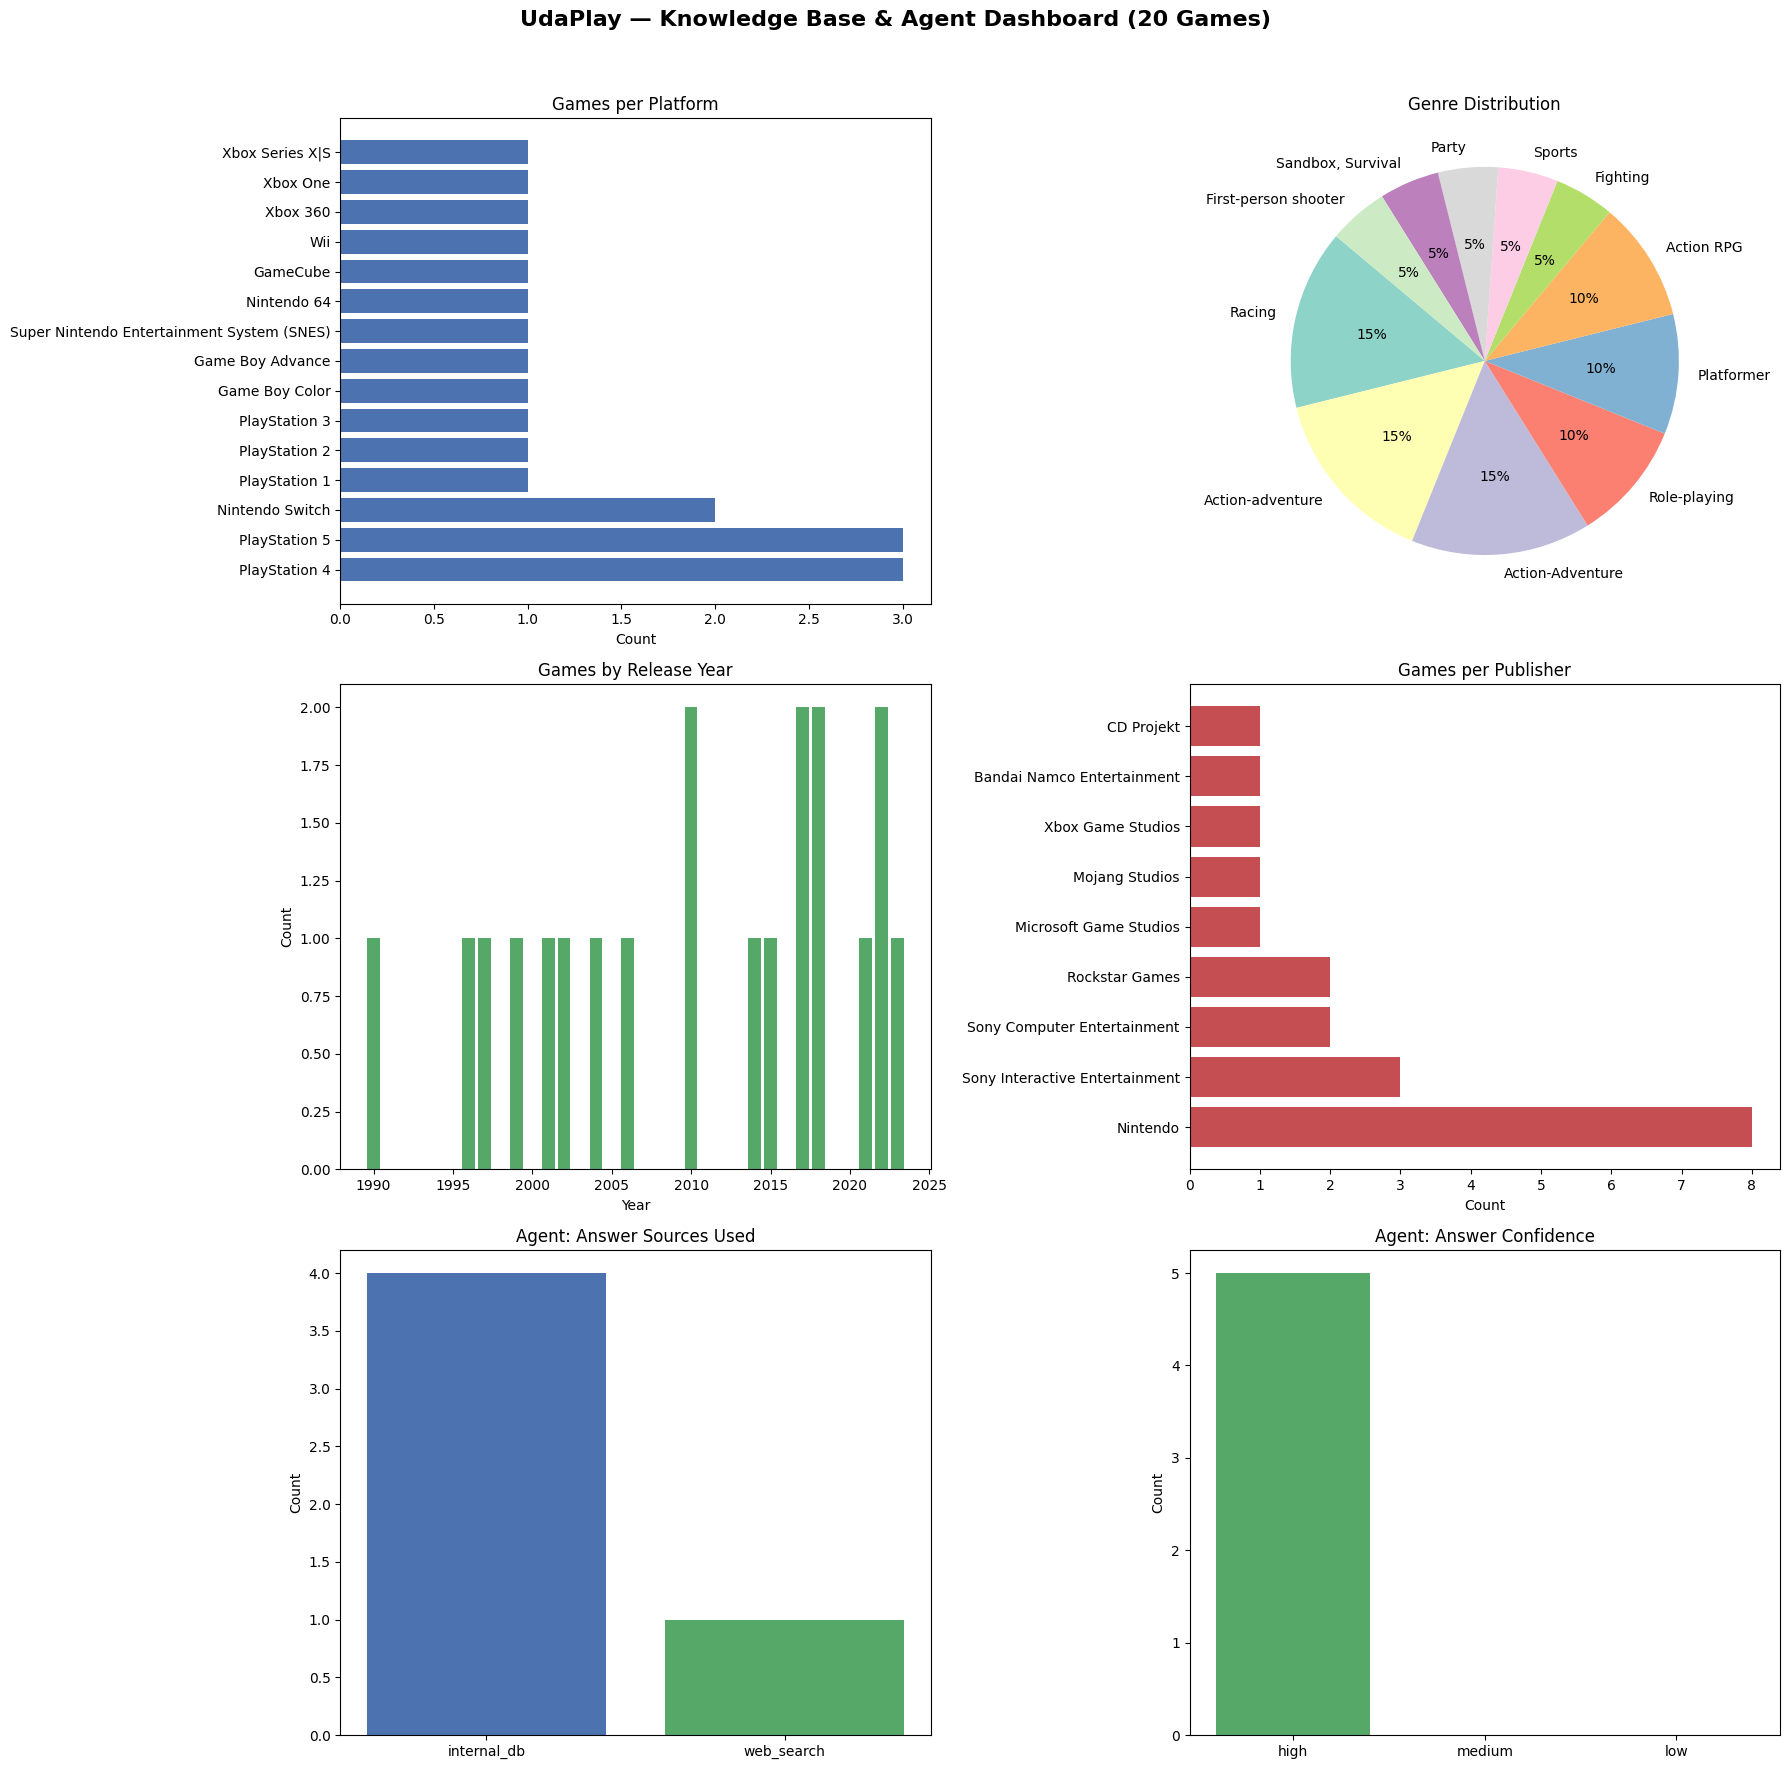


Dashboard saved to udaplay_advanced_dashboard.png


In [34]:
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
matplotlib.rcParams.update({"font.size": 10})

# Data prep from expanded 20-game dataset
platforms  = [g["Platform"] for g in all_games]
genres     = [g["Genre"]    for g in all_games]
publishers = [g["Publisher"] for g in all_games]
years      = sorted([g["YearOfRelease"] for g in all_games])

# Prep agent performance data from structured_answers
source_counts = Counter()
confidence_counts = Counter()
for sa in structured_answers:
    for s in sa.sources:
        source_counts[s] += 1
    confidence_counts[sa.confidence] += 1

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("UdaPlay — Knowledge Base & Agent Dashboard (20 Games)", fontsize=16, fontweight="bold")

# 1) Games per platform
plat_counts = Counter(platforms)
plat_sorted = plat_counts.most_common()
axes[0, 0].barh([p for p, _ in plat_sorted], [c for _, c in plat_sorted], color="#4C72B0")
axes[0, 0].set_title("Games per Platform")
axes[0, 0].set_xlabel("Count")

# 2) Genre distribution
genre_counts = Counter(genres)
labels, sizes = zip(*genre_counts.most_common())
colors = plt.cm.Set3.colors[:len(labels)]
axes[0, 1].pie(sizes, labels=labels, autopct="%1.0f%%", colors=colors, startangle=140)
axes[0, 1].set_title("Genre Distribution")

# 3) Release year timeline
year_counts = Counter(years)
all_years_range = list(range(min(years), max(years) + 1))
counts = [year_counts.get(y, 0) for y in all_years_range]
axes[1, 0].bar(all_years_range, counts, color="#55A868", width=0.8)
axes[1, 0].set_title("Games by Release Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Count")

# 4) Publisher breakdown
pub_counts = Counter(publishers)
pub_sorted = pub_counts.most_common()
axes[1, 1].barh([p for p, _ in pub_sorted], [c for _, c in pub_sorted], color="#C44E52")
axes[1, 1].set_title("Games per Publisher")
axes[1, 1].set_xlabel("Count")

# 5) Agent source usage (how the agent found answers)
if source_counts:
    src_labels, src_sizes = zip(*source_counts.most_common())
    src_colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"][:len(src_labels)]
    axes[2, 0].bar(src_labels, src_sizes, color=src_colors)
    axes[2, 0].set_title("Agent: Answer Sources Used")
    axes[2, 0].set_ylabel("Count")
else:
    axes[2, 0].text(0.5, 0.5, "No data yet", ha='center', va='center')
    axes[2, 0].set_title("Agent: Answer Sources Used")

# 6) Agent confidence distribution
if confidence_counts:
    conf_labels = ["high", "medium", "low"]
    conf_sizes = [confidence_counts.get(c, 0) for c in conf_labels]
    conf_colors = ["#55A868", "#CCB974", "#C44E52"]
    axes[2, 1].bar(conf_labels, conf_sizes, color=conf_colors)
    axes[2, 1].set_title("Agent: Answer Confidence")
    axes[2, 1].set_ylabel("Count")
else:
    axes[2, 1].text(0.5, 0.5, "No data yet", ha='center', va='center')
    axes[2, 1].set_title("Agent: Answer Confidence")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("udaplay_advanced_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("\nDashboard saved to udaplay_advanced_dashboard.png")

### Memory Persistence Demo — Agent Learns From Past Queries

In [35]:
# Lets first ask a question that requires web search, agent memorizes it,
# then ask the same question again — agent recalls from memory

print("FIRST ASK (will search web + memorize)")
run1 = agent.invoke("When was the last FIFA game released and what replaced it?")
state1 = run1.get_final_state()
print(f"\nAnswer: {state1['messages'][-1].content}")
print(f"Tokens: {state1.get('total_tokens', 'N/A')}")

# Don't reset — ask follow-up in same session to show conversation state
print("\n\nFOLLOW-UP (should recall from memory or conversation)")
run2 = agent.invoke("Can you remind me what replaced FIFA?")
state2 = run2.get_final_state()
print(f"\nAnswer: {state2['messages'][-1].content}")
print(f"Tokens: {state2.get('total_tokens', 'N/A')}")

agent.reset_session()

FIRST ASK (will search web + memorize)
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Answer: The latest FIFA game, FIFA Heroes, was released in October 2025. It was succeeded by FIFA 26 in 2026.
Tokens: 4543


FOLLOW-UP (should recall from memory or conversation)
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Answer: The game that replaced FIFA was FIFA 26, released in 2026.
Tokens: 1429
